# Laboratorio 3 - Parte 1

### Modelos de mezclas de funciones Gausianas y k-means

### 2018-II

#### Profesor: Julián D. Arias Londoño
#### julian.ariasl@udea.edu.co


## Guía del laboratorio

En este archivo va a encontrar tanto celdas de código cómo celdas de texto con las instrucciones para desarrollar el laboratorio.

Lea atentamente las instrucciones entregadas en las celdas de texto correspondientes y proceda con la solución de las preguntas planteadas.

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [ ]:
#Tomado de https://github.com/rramosp/mooc-grader
from Autentication import *#python 3
import inspect, urllib
html, auth_code, userinfo = google_authenticate(PORT_NUMBER=8080)
html

#### Segundo integrante:

In [98]:
from __future__ import division
%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import collections
from scipy import stats

#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("always")

## Ejercicio 1

A continuación se leen los datos de un problema de clasificación. El problema corresponde a la clasifiación de dígitos escritos a mano. Usaremos únicamente 4 de las 10 clases disponibles. Los datos fueron preprocesados para reducir el número de características. La técnica usada será analizada más adelante en el curso.

In [99]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
digits = load_digits(n_class=4)

#--------- preprocesamiento--------------------
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)

#---------- Datos a usar ----------------------
X = data
Y = digits.target

Un vistazo a la base de datos

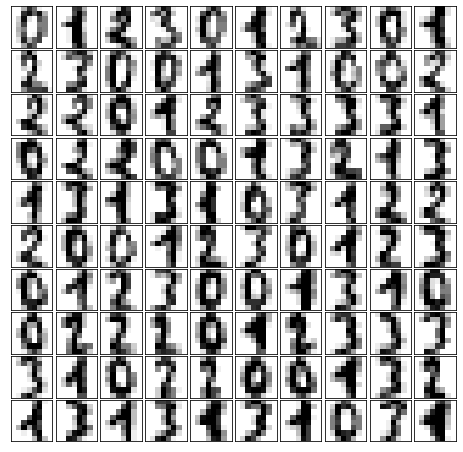

In [100]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Responda:

1.1 ¿Cuántas muestras por clase tiene la base de datos?:

In [101]:
muestrasPorClase = collections.Counter(Y)
respuesta_1 = "La base de datos tiene:\n\n"
for key, value in muestrasPorClase.items():
    respuesta_1 += str(value) + " muestras de la clase " + str(key) + "\n"
print(respuesta_1)

La base de datos tiene:

178 muestras de la clase 0
182 muestras de la clase 1
177 muestras de la clase 2
183 muestras de la clase 3



1.2 ¿Cuántas características tiene cada muestra?

In [102]:
n_muestras, n_caracteristicas = X.shape
"Cada muestra cuenta con " + str(n_caracteristicas) + " características."

'Cada muestra cuenta con 39 características.'

1.3 Teniendo en cuenta el tipo de problema y el número de muestras por clase, ¿qué metodología de validación debería usar?¿Porqué?:

Se debe utilizar la metodología de validación _cross validation (validación cruzada)_ en _k-folds_ porque esto nos permite encontrar el mejor valor de $M$

In [38]:
muestras, caracteristicas = X.shape
muestras_por_clase = collections.Counter(Y)
respuesta_1 = 'Respuestas:\n1.1. La base de datos cuenta con:\n\n'
for key, value in muestras_por_clase.items():
    respuesta_1 += str(value) + ' muestras para la clase ' + str(key) + '.\n'
print(respuesta_1)
print('1.2. Cada muestra cuenta con', caracteristicas,'características.')

Respuestas:
1.1. La base de datos cuenta con:

178 muestras para la clase 0.
182 muestras para la clase 1.
177 muestras para la clase 2.
183 muestras para la clase 3.

1.2. Cada muestra cuenta con 39 características.


En la siguiente celda defina una función que tome como entradas una matriz X y una matriz Y, entrene un modelo GMM por cada clase y retorne el listado de modelos para cada clase. Adicionalmente construya una función que use los modelos entrenados en la función anterior para hacer la clasificación de un conjunto nuevo de muestras.

In [103]:
def GMMClassifierTrain(X,Y,M,tipo):
    
    #X: Matriz con las características
    #Y: Matriz con las clases
    #M: Número de componentes
    #tipo: Tipo de matriz de covarianza
    GMMs=[]
    
    for i in np.unique(Y):
        Xtrain= X[Y==i, :]
        models_per_class = GaussianMixture(n_components=M, covariance_type=tipo);
        #Train the other parameters using the EM algorithm.
        models_per_class.fit(Xtrain)
        GMMs.append(models_per_class)
        
    return GMMs #Debe retornar un objeto que contenga todos los modelos entrenados




def GMMClassfierVal(GMMs,Xtest):
    
    n_Xtest = Xtest.shape[0];
    n_models_per_class = len(GMMs)
    probability = np.zeros((n_Xtest, n_models_per_class)) #Probabilidad
    for i in range(n_models_per_class):
        probability[:, i] = np.exp(GMMs[i].score_samples(Xtest)) #Calcula el peso de las muestras   
    Yest = np.argmax(probability, axis=1)
    
    return Yest #Debe retornar un vector con las clases predichas para cada una de las muestras en Xtest, de acuerdo con los modelos almacenados en GMMs

En la siguiente celda se define una simulación para entrenar y validar un modelo usando los datos previamente cargados. Complete el código para usar como modelo de predicción un GMM. Debe consultar todo lo relacionado con la creación, entrenamiento y uso en predicción de este modelo usando la librería scikit-learn. Consultar aquí: http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [104]:
import math
import numpy as np
import numpy.matlib
from numpy import random
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold


#Validamos el modelo

matrix_types = ['full','full','full','full','full','full','diag','diag','diag','diag','diag','diag','spherical','spherical','spherical','spherical','spherical','spherical','tied','tied','tied','tied','tied','tied']
components = [1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6]
table = []
for component, matrix_type in zip(components, matrix_types):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]
        
        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)
        
        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        gmms =  GMMClassifierTrain(Xtrain,Ytrain,component,matrix_type)
        
        
        
        #Validación
        Ytrain_pred = GMMClassfierVal(gmms,Xtrain);
        Yest = GMMClassfierVal(gmms,Xtest);
        
        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(Ytrain_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(Yest.ravel() == Ytest.ravel())
        j += 1
    table.append((str(np.mean(EficienciaVal)),  str(np.std(EficienciaVal))))   
    print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))


Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9834479272694958+-0.014043974572147429
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.9681536008332576+-0.013022908857458793
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.912416908045111+-0.029747965775809456
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.6899249310119687+-0.12103174952956765
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.5173994995516398+-0.09648566591263898
Eficiencia durante el entrenamiento = 1.0+-0.0
Eficiencia durante la validación = 0.4084583510698063+-0.028087280561425322
Eficiencia durante el entrenamiento = 0.9874913312685584+-0.004034179257013327
Eficiencia durante la validación = 0.9263682245912502+-0.010018017854166889
Eficiencia durante el entrenamiento = 0.9953677586353733+-0.0009388043015629532
Eficiencia durante la validaci

In [105]:
print(table)

[('0.9834479272694958', '0.014043974572147429'), ('0.9681536008332576', '0.013022908857458793'), ('0.912416908045111', '0.029747965775809456'), ('0.6899249310119687', '0.12103174952956765'), ('0.5173994995516398', '0.09648566591263898'), ('0.4084583510698063', '0.028087280561425322'), ('0.9263682245912502', '0.010018017854166889'), ('0.9374956257062395', '0.010621933451619608'), ('0.9555068542222571', '0.022967890779648337'), ('0.9388307921172456', '0.02385056736246423'), ('0.9471808499170888', '0.028432202861579572'), ('0.9597269003571771', '0.015902086832139072'), ('0.8833235614651569', '0.01876983809647873'), ('0.8556150203006674', '0.026736626379277973'), ('0.8820749419984606', '0.02336139156541426'), ('0.8486691996415039', '0.011851570184303054'), ('0.8666948317672297', '0.006126847612538244'), ('0.8709242705457736', '0.026772464765403185'), ('0.9834479272694958', '0.014043974572147429'), ('0.9848215536431222', '0.013148860054575707'), ('0.9834479272694958', '0.014043974572147429'

## Ejercicio 2

Una vez completado el código realice los experimentos necesarios para llenar la siguiente tabla:

In [107]:
import pandas as pd
import qgrid

i = 0

randn = np.random.randn
df_types = pd.DataFrame({
    'Matriz de covarianza' : pd.Series(['Completa','Completa','Completa','Completa','Completa','Completa','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Diagonal','Esférica','Esférica','Esférica','Esférica','Esférica','Esférica','Atada','Atada','Atada','Atada','Atada','Atada']),
    'Numero de componentes' : pd.Series([1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6])})
df_types["Eficiencia en validacion"] = ""
df_types["Intervalo de confianza"] = ""
df_types.set_index(['Matriz de covarianza','Numero de componentes'], inplace=True)
for validacion, intervalo in table:
    df_types["Eficiencia en validacion"][i] = validacion
    df_types["Intervalo de confianza"][i] = intervalo
    i += 1
    #df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Ejecute la siguiente instrucción para dejar guardados en el notebook los resultados de las pruebas.


In [108]:
qgrid_widget.get_changed_df()

Eficiencia en validacion  \
Matriz de covarianza Numero de componentes                            
Completa             1                           0.9834479272694958   
                     2                           0.9681536008332576   
                     3                            0.912416908045111   
                     4                           0.6899249310119687   
                     5                           0.5173994995516398   
                     6                           0.4084583510698063   
Diagonal             1                           0.9263682245912502   
                     2                           0.9374956257062395   
                     3                           0.9555068542222571   
                     4                           0.9388307921172456   
                     5                           0.9471808499170888   
                     6                           0.9597269003571771   
Esférica             1                           0.8833235614651569   
                     2                           0.8556150203006674   
                     3                           0.8820749419984606   
                     4                           0.8486691996415039   
                     5                           0.8666948317672297   
                     6                           0.8709242705457736   
Atada                1                           0.9834479272694958   
                     2                           0.9848215536431222   
                     3                           0.9834479272694958   
                     4                           0.9820434328874733   
                     5                           0.9834479272694958   
                     6                           0.9875839845823486   

                                           Intervalo de confianza  
Matriz de covarianza Numero de componentes                         
Completa             1                       0.014043974572147429  
                     2                       0.013022908857458793  
                     3                       0.029747965775809456  
                     4                        0.12103174952956765  
                     5                        0.09648566591263898  
                     6                       0.028087280561425322  
Diagonal             1                       0.010018017854166889  
                     2                       0.010621933451619608  
                     3                       0.022967890779648337  
                     4                        0.02385056736246423  
                     5                       0.028432202861579572  
                     6                       0.015902086832139072  
Esférica             1                        0.01876983809647873  
                     2                       0.026736626379277973  
                     3                        0.02336139156541426  
                     4                       0.011851570184303054  
                     5                       0.006126847612538244  
                     6                       0.026772464765403185  
Atada                1                       0.014043974572147429  
                     2                       0.013148860054575707  
                     3                       0.014043974572147429  
                     4                       0.012516247395640619  
                     5                       0.014043974572147429  
                     6                       0.009823432282667867

Responda

2.1 La tabla incluye un tipo de matriz de covarianza no visto en clase, Atada, ¿En qué consiste este tipo de matriz según la documentación en scikit-learn?:
**R//** Usar este tipo de matriz de covarianza implica que todos los componentes tienen la misma matriz de covarianza


2.2  ¿Qué método se utilizó para la incialización de los parámetros del modelo GMM?:
**R//** Por defecto la librería utiliza el método de kmeans para inicializar la media, varianza y pesos. 


2.3 ¿El algoritmo EM presentó problemas de convergencia o colapso para alguna de las combinaciones de parámetros?
**R//** Según lo evidenciado en el comportamiento del algoritmo, al no arrojar ningún valor indefinido o no numérico, se puede concluir que no tuvimos problemas de convergencia o colapso para alguna de las combinaciones de parámetros.

## Ejercicio 3

En la siguiente celda, utilice las muestras de la base de datos iris incluidos en la variable Xclustering. Lleve a cabo el agrupamiento de los datos usando el algoritmo k-means y el modelo GMM. Consultar todo lo relacionado al llamado del método KMeans de la librería scikit-learn en el siguiente enlace: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. Realice el agrupamiento para 2 y 3 grupos y grafique los resultados del agrupamiento en cada caso (use colores para los puntos de acuerdo con el grupo asignado por el algoritmo de agrupamiento). Para el caso del GMM use una matriz de covarianza completa y una matriz diagonal. El resultado de este punto son 6 gráficas.

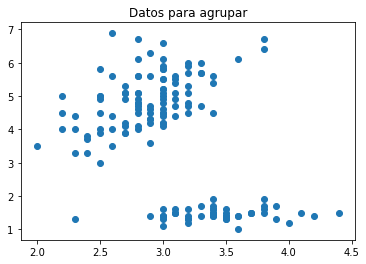

In [114]:
from sklearn.datasets import load_iris
data = load_iris()
X=data.data
Y_iris=data.target
Xclustering = X[:,1:3]
plt.scatter(Xclustering[:,0],Xclustering[:,1])
plt.title("Datos para agrupar")
plt.show()

Método de clusterizado con K-means:


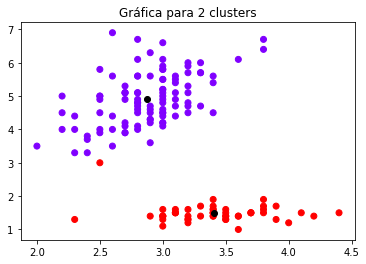

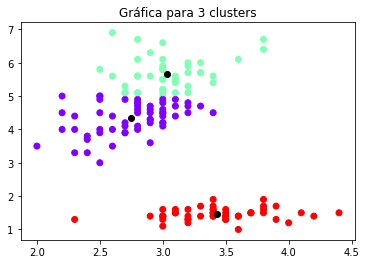

Método de clusterizado con GMM (Gaussian Mixture Model):


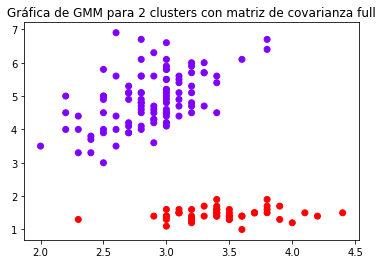

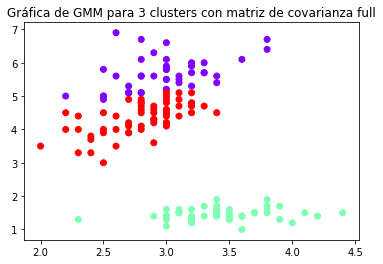

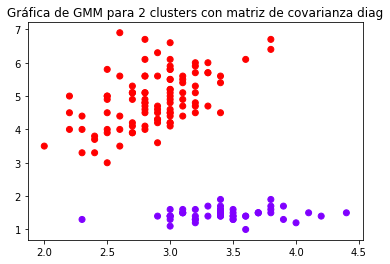

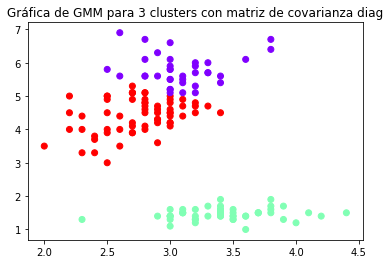

In [140]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
import matplotlib as mpl
# Procedimiento para el agrupamiento con 2 clusters
print('Método de clusterizado con K-means:')
n_centroids_to_generate = 2
k_means = KMeans(n_clusters=n_centroids_to_generate, init='k-means++', n_jobs=-1, algorithm='auto').fit(Xclustering)
plt.title("Gráfica para 2 clusters")
plt.scatter(Xclustering[:,0],Xclustering[:,1], c=k_means.labels_, cmap='rainbow')
plt.scatter(k_means.cluster_centers_[:,0] ,k_means.cluster_centers_[:,1], color='black')
plt.show()
# Procedimiento para el agrupamiento con 3 clusters
n_centroids_to_generate = 3
plt.title("Gráfica para 3 clusters")
k_means = KMeans(n_clusters=n_centroids_to_generate, init='k-means++', n_jobs=-1, algorithm='auto').fit(Xclustering)
k_means.labels_
plt.scatter(Xclustering[:,0],Xclustering[:,1], c=k_means.labels_, cmap='rainbow')
plt.scatter(k_means.cluster_centers_[:,0] ,k_means.cluster_centers_[:,1], color='black')
plt.show()
########################### Gaussian Mixture Models (Modelos de Mezclas Gaussianas)
print('Método de clusterizado con GMM (Gaussian Mixture Model):')
from sklearn.mixture import GaussianMixture
for types, components in zip(['full','full','diag','diag'],[2,3,2,3]):
    GMM = GaussianMixture(n_components=components, covariance_type=types).fit(Xclustering)
    labels = GMM.predict(Xclustering)
    plt.title("Gráfica de GMM para " + str(components) + " clusters con matriz de covarianza " + types)
    plt.scatter(Xclustering[:,0],Xclustering[:,1],c=labels,cmap='rainbow')
    plt.show()